# Supervised Fine Tuning (STF) with Gemini for Article Summarization



## Wikilingua Dataset

The dataset includes article and summary pairs from WikiHow. It consists of  article-summary pairs in multiple languages. Refer to the following [github repository](https://github.com/esdurmus/Wikilingua) for more details.

For this notebook, we have picked `english` language dataset.

### Dataset Citation

```
@inproceedings{ladhak-wiki-2020,
    title={WikiLingua: A New Benchmark Dataset for Multilingual Abstractive Summarization},
    author={Faisal Ladhak, Esin Durmus, Claire Cardie and Kathleen McKeown},
    booktitle={Findings of EMNLP, 2020},
    year={2020}
}
```

### Install Gen AI SDK and other required packages

In [1]:
%pip install --upgrade --user --quiet google-genai google-cloud-aiplatform rouge_score plotly jsonlines

  DEPRECATION: Building 'rouge_score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge_score'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


### Restart runtime

To use the newly installed packages, you must restart the runtime.


In [27]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

## Import libraries

In [1]:
import time

from google import genai

# For extracting vertex experiment details.
from google.cloud import aiplatform
from google.cloud.aiplatform.metadata import context
from google.cloud.aiplatform.metadata import utils as metadata_utils
from google.genai import types

# For data handling.
import jsonlines
import pandas as pd

# For visualization.
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For evaluation metric computation.
from rouge_score import rouge_scorer
from tqdm import tqdm

# For fine tuning Gemini model.
import vertexai

## Step2: Set Google Cloud project information and initialize Vertex AI and Gen AI SDK



In [ ]:
PROJECT_ID = "ofcourse_cant_reveal_lol_did_you_to _here_thanks:)"  
REGION = "us-central1" 

In [3]:
vertexai.init(project=PROJECT_ID, location=REGION)

client = genai.Client(vertexai=True, project=PROJECT_ID, location=REGION)

## Step3: Create a dataset in the required format

The dataset used to tune a foundation model needs to include examples that align with the task that you want the model to perform. Structure your training dataset in a text-to-text format. Each record, or row, in the dataset contains the input text (also referred to as the prompt) which is paired with its expected output from the model. Supervised tuning uses the dataset to teach the model to mimic a behavior, or task, you need by giving it hundreds of examples that illustrate that behavior.

Your dataset size depends on the task, and follows the recommendation mentioned in the `Overview` section. The more examples you provide in your dataset, the better the results.

### Dataset format

Training data should be structured within a JSONL file located at a Google Cloud Storage (GCS) URI. Each line (or row) of the JSONL file must adhere to a specific schema: It should contain a `contents` array, with objects inside defining a `role` (either "user" for user input or "model" for model output) and `parts`, containing the input data. For example, a valid data row would look like this:


```
{
   "contents":[
      {
         "role":"user",  # This indicate input content
         "parts":[
            {
               "text":"How are you?"
            }
         ]
      },
      {
         "role":"model", # This indicate target content
         "parts":[ # text only
            {
               "text":"I am good, thank you!"
            }
         ]
      }
      #  ... repeat "user", "model" for multi turns.
   ]
}
```


Refer to the public [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/gemini-supervised-tuning-prepare#about-datasets) for more details.

To run a tuning job, you need to upload one or more datasets to a Cloud Storage bucket. You can either create a new Cloud Storage bucket or use an existing one to store dataset files. The region of the bucket doesn't matter, but we recommend that you use a bucket that's in the same Google Cloud project where you plan to tune your model.

### Step3 [a]: Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.


In [ ]:
BUCKET_NAME = "adityaisgoingtofinetune"
BUCKET_URI = f"gs://{BUCKET_NAME}"

### Step3 [b]: Upload tuning data to Cloud Storage

- Data used in this notebook is present in the public Google Cloud Storage(GCS) bucket.
- It's in Gemini finetuning dataset format

In [6]:
!gsutil ls gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua

gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/
gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_test_samples.csv
gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_train_samples.jsonl
gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_val_samples.jsonl


In [7]:
!gsutil cp gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/* .

Copying gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_test_samples.csv...
Copying gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_train_samples.jsonl...
Copying gs://github-repo/generative-ai/gemini/tuning/summarization/wikilingua/sft_val_samples.jsonl...
/ [3 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 3 objects/1.6 MiB.                                      


#### Convert Gemini tuning dataset to Gemini 2.0 tuning dataset format

In [9]:
def save_jsonlines(file, instances):
    """
    Saves a list of json instances to a jsonlines file.
    """
    with jsonlines.open(file, mode="w") as writer:
        writer.write_all(instances)

In [10]:
def create_tuning_samples(file_path):
    """
    Creates tuning samples from a file.
    """
    with jsonlines.open(file_path) as reader:
        instances = []
        for obj in reader:
            instance = []
            for content in obj["messages"]:
                instance.append(
                    {"role": content["role"], "parts": [{"text": content["content"]}]}
                )
            instances.append({"contents": instance})
    return instances

In [11]:
train_file = "sft_train_samples.jsonl"
train_instances = create_tuning_samples(train_file)
len(train_instances)

500

In [13]:
# save the training instances to jsonl file
save_jsonlines(train_file, train_instances)

In [14]:
val_file = "sft_val_samples.jsonl"
val_instances = create_tuning_samples(val_file)
len(val_instances)

100

In [15]:
# save the validation instances to jsonl file
save_jsonlines(val_file, val_instances)

In [16]:
# Copy the tuning and evaluation data to your bucket.
!gsutil cp {train_file} {BUCKET_URI}/train/
!gsutil cp {val_file} {BUCKET_URI}/val/

Copying file://sft_train_samples.jsonl [Content-Type=application/octet-stream]...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      
Copying file://sft_val_samples.jsonl [Content-Type=application/octet-stream]...
/ [1 files][231.8 KiB/231.8 KiB]                                                
Operation completed over 1 objects/231.8 KiB.                                    


### Step3 [c]: Test dataset

- It contains document text(`input_text`) and corresponding reference summary(`output_text`), which will be compared with the model generated summary

In [17]:
# Load the test dataset using pandas as it's in the csv format.
testing_data_path = "sft_test_samples.csv"
test_data = pd.read_csv(testing_data_path)
test_data.head()

,input_text,output_text
0,Hold your arm out flat in front of you with yo...,Squeeze a line of lotion onto the tops of both...
1,"As you continue playing, surviving becomes pai...",Make a Crock Pot for better food. Create an Al...
2,Go to https://www.4kdownload.com/products/prod...,Download the 4K Video Downloader setup file. I...
3,You should know that vaginoplasty can treat a ...,Consider the health of your bladder. Find a so...
4,If you want to gather data on the frequency of...,Gather data to be graphed. Choose your range b...


In [18]:
test_data.loc[0, "input_text"]

'Hold your arm out flat in front of you with your elbow bent. The top of your forearm should form a level surface. Apply a line of lotion from the back of your hand up your arm almost to the crease of your elbow. Squeeze lotion onto both forearms.  Do not rub the lotion into your arms, rather let it sit on your arm in the line you squeezed. You can use as much or as little lotion as you feel is necessary to cover your back completely. Bend your elbows and reach both of your arms behind you, placing the lotion covered forearms against your back. Depending on how flexible you are, this may hurt a little. It might be easier to place one arm behind your back at a time. If you have shoulder pain or are not very flexible, this method may not work well for you. Rub your forearms and the backs of your hands up and down your back like windshield wipers covering as much of your back as you can. You can use your left arm first to cover your left side and then place your right arm behind and use i

In [19]:
# Article summary stats
stats = test_data["output_text"].apply(len).describe()
stats

count    100.000000
mean     186.230000
std       92.788655
min       28.000000
25%      127.250000
50%      171.000000
75%      227.000000
max      577.000000
Name: output_text, dtype: float64

In [20]:
print(f"Total `{stats['count']}` test records")
print(f"Average length is `{stats['mean']}` and max is `{stats['max']}` characters")
print("\nConsidering 1 token = 4 chars")

# Get ceil value of the tokens required.
tokens = (stats["max"] / 4).__ceil__()
print(
    f"\nSet max_token_length = stats['max']/4 = {stats['max']/4} ~ {tokens} characters"
)
print(f"\nLet's keep output tokens upto `{tokens}`")

Total `100.0` test records
Average length is `186.23` and max is `577.0` characters

Considering 1 token = 4 chars

Set max_token_length = stats['max']/4 = 144.25 ~ 145 characters

Let's keep output tokens upto `145`


In [ ]:
max_output_tokens = tokens

## Step4: Initialize the model

The following Gemini text model supports supervised tuning:

* `gemini-2.0-flash-001`

In [22]:
base_model = "gemini-2.0-flash-001"

## Step5: Test the Gemini model

### Generation config

- Each call that you send to a model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values
- <strong>Experiment</strong> with different parameter values to get the best values for the task

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/adjust-parameter-values) for understanding different parameters

**Prompt** is a natural language request submitted to a language model to receive a response back

Some best practices include
  - Clearly communicate what content or information is most important
  - Structure the prompt:
    - Defining the role if using one. For example, You are an experienced UX designer at a top tech company
    - Include context and input data
    - Provide the instructions to the model
    - Add example(s) if you are using them

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/prompt-design-strategies) for prompt design strategies.

Wikilingua data contains the following task prompt at the end of the article, `Provide a summary of the article in two or three sentences:`

In [23]:
test_doc = test_data.loc[0, "input_text"]

prompt = f"""
{test_doc}
"""

config = {
    "temperature": 0.1,
    "max_output_tokens": max_output_tokens,
}

response = client.models.generate_content(
    model=base_model,
    contents=prompt,
    config=config,
).text
print(response)

This article describes a method for applying lotion to your back using your forearms as applicators. It involves squeezing lotion onto your forearms and then using them to rub the lotion across your back in a windshield wiper motion. The method acknowledges potential limitations for individuals with shoulder pain or limited flexibility.



In [ ]:
test_data.loc[0, "output_text"]

'Squeeze a line of lotion onto the tops of both forearms and the backs of your hands. Place your arms behind your back. Move your arms in a windshield wiper motion.'

## Step6: Evaluation before model tuning

- Evaluate the Gemini model on the test dataset before tuning it on the training dataset.

In [ ]:
corpus = test_data.to_dict(orient="records")
len(corpus)

100

### Evaluation metric

The type of metrics used for evaluation depends on the task that you are evaluating. The following table shows the supported tasks and the metrics used to evaluate each task:

| Task             | Metric(s)                     |
|-----------------|---------------------------------|
| Classification   | Micro-F1, Macro-F1, Per class F1 |
| Summarization    | ROUGE-L                         |
| Question Answering | Exact Match                     |
| Text Generation  | BLEU, ROUGE-L                   |


<br/>

Refer to this [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluate-models) for metric based evaluation.

- **Recall-Oriented Understudy for Gisting Evaluation (ROUGE)**: A metric used to evaluate the quality of automatic summaries of text. It works by comparing a generated summary to a set of reference summaries created by humans.

Now you can take the candidate and reference to evaluate the performance. In this case, ROUGE will give you:

- `rouge-1`, which measures unigram overlap
- `rouge-2`, which measures bigram overlap
- `rouge-l`, which measures the longest common subsequence

#### *Recall vs. Precision*

**Recall**, meaning it prioritizes how much of the information in the reference summaries is captured in the generated summary.

**Precision**, which measures how much of the generated summary is relevant to the original text.

<strong>Alternate Evaluation method</strong>: Check out the [AutoSxS](https://cloud.google.com/vertex-ai/generative-ai/docs/models/side-by-side-eval) evaluation for automatic evaluation of the task.


In [ ]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

In [30]:
def run_evaluation(model, corpus: list[dict]) -> pd.DataFrame:
    """Runs evaluation for the given model and data.

    Args:
      model: The generation model.
      corpus: The test data.

    Returns:
      A pandas DataFrame containing the evaluation results.
    """
    records = []
    for item in tqdm(corpus):
        document = item.get("input_text")
        summary = item.get("output_text")

        # Catch any exception that occur during model evaluation.
        try:
            response = client.models.generate_content(
                model=model,
                contents=document,
                config=config,
            )

            # Check if response is generated by the model, if response is empty then continue to next item.
            if not (
                response
                and response.candidates
                and response.candidates[0].content.parts
            ):
                print(
                    f"\nModel has blocked the response for the document.\n Response: {response}\n Document: {document}"
                )
                continue

            # Calculates the ROUGE score for a given reference and generated summary.
            scores = scorer.score(target=summary, prediction=response.text)

            # Append the results to the records list
            records.append(
                {
                    "document": document,
                    "summary": summary,
                    "generated_summary": response.text,
                    "scores": scores,
                    "rouge1_precision": scores.get("rouge1").precision,
                    "rouge1_recall": scores.get("rouge1").recall,
                    "rouge1_fmeasure": scores.get("rouge1").fmeasure,
                    "rouge2_precision": scores.get("rouge2").precision,
                    "rouge2_recall": scores.get("rouge2").recall,
                    "rouge2_fmeasure": scores.get("rouge2").fmeasure,
                    "rougeL_precision": scores.get("rougeL").precision,
                    "rougeL_recall": scores.get("rougeL").recall,
                    "rougeL_fmeasure": scores.get("rougeL").fmeasure,
                }
            )
        except AttributeError as attr_err:
            print("Attribute Error:", attr_err)
            continue
        except Exception as err:
            print("Error:", err)
            continue
    return pd.DataFrame(records)

In [31]:
# Batch of test data.
corpus_batch = corpus[:100]

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~5 mins for the evaluation run on the provided batch. ⚠️</b>
</div>

In [32]:
# Run evaluation using loaded model and test data corpus
evaluation_df = run_evaluation(base_model, corpus_batch)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


In [33]:
evaluation_df.head()

,document,summary,generated_summary,scores,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,Hold your arm out flat in front of you with yo...,Squeeze a line of lotion onto the tops of both...,This article describes a method for applying l...,"{'rouge1': (0.3137254901960784, 0.516129032258...",0.313725,0.516129,0.390244,0.080000,0.133333,0.100000,0.196078,0.322581,0.243902
1,"As you continue playing, surviving becomes pai...",Make a Crock Pot for better food. Create an Al...,"To survive longer in the game, players need to...","{'rouge1': (0.30612244897959184, 0.83333333333...",0.306122,0.833333,0.447761,0.062500,0.176471,0.092308,0.183673,0.500000,0.268657
2,Go to https://www.4kdownload.com/products/prod...,Download the 4K Video Downloader setup file. I...,This article provides step-by-step instruction...,"{'rouge1': (0.4186046511627907, 0.305084745762...",0.418605,0.305085,0.352941,0.095238,0.068966,0.080000,0.325581,0.237288,0.274510
3,You should know that vaginoplasty can treat a ...,Consider the health of your bladder. Find a so...,Vaginoplasty can be a solution for a prolapsed...,"{'rouge1': (0.26785714285714285, 0.53571428571...",0.267857,0.535714,0.357143,0.090909,0.185185,0.121951,0.160714,0.321429,0.214286
4,If you want to gather data on the frequency of...,Gather data to be graphed. Choose your range b...,Histograms are useful for visualizing the freq...,"{'rouge1': (0.25862068965517243, 0.65217391304...",0.258621,0.652174,0.370370,0.087719,0.227273,0.126582,0.224138,0.565217,0.320988


In [35]:
evaluation_df_stats = evaluation_df.dropna().describe()

In [36]:
# Statistics of the evaluation dataframe.
evaluation_df_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.227744,0.407047,0.273725,0.049879,0.093446,0.060869,0.148825,0.275474,0.181116
std,0.104968,0.155715,0.098666,0.045402,0.086418,0.054015,0.067785,0.124190,0.070995
min,0.023810,0.083333,0.044444,0.000000,0.000000,0.000000,0.023810,0.079646,0.044444
25%,0.147996,0.287775,0.200000,0.018022,0.030890,0.023955,0.095925,0.179872,0.132609
50%,0.212940,0.384921,0.269943,0.040000,0.071921,0.046319,0.133756,0.259486,0.167249
75%,0.302277,0.520682,0.352941,0.069227,0.134091,0.086151,0.191863,0.333333,0.224971
max,0.619048,0.833333,0.488889,0.195122,0.363636,0.242424,0.357143,0.615385,0.378947


In [37]:
print("Mean rougeL_precision is", evaluation_df_stats.rougeL_precision["mean"])

Mean rougeL_precision is 0.148824721413922


## Step7: Fine-tune the model

 - `source_model`: Specifies the base Gemini model version you want to fine-tune.
 - `train_dataset`: Path to your training data in JSONL format.

  *Optional parameters*
 - `validation_dataset`: If provided, this data is used to evaluate the model during tuning.
 - `tuned_model_display_name`: Display name for the tuned model.
 - `epochs`: The number of training epochs to run.
 - `learning_rate_multiplier`: A value to scale the learning rate during training.
 - `adapter_size` : Gemini 2.0 Pro supports Adapter length [1, 2, 4, 8], default value is 4.

**Note: The default hyperparameter settings are optimized for optimal performance based on rigorous testing and are recommended for initial use. Users may customize these parameters to address specific performance requirements.**

In [38]:
tuned_model_display_name = "[DISPLAY NAME FOR TUNED MODEL]"  # @param {type:"string"}

training_dataset = {
    "gcs_uri": f"{BUCKET_URI}/train/sft_train_samples.jsonl",
}

validation_dataset = types.TuningValidationDataset(
    gcs_uri=f"{BUCKET_URI}/val/sft_val_samples.jsonl"
)

# Tune a model using `tune` method.
sft_tuning_job = client.tunings.tune(
    base_model=base_model,
    training_dataset=training_dataset,
    config=types.CreateTuningJobConfig(
        tuned_model_display_name=tuned_model_display_name,
        validation_dataset=validation_dataset,
    ),
)

/var/tmp/ipykernel_5468/2623409050.py:12: ExperimentalWarning: The SDK's tuning implementation is experimental, and may change in future versions.
  sft_tuning_job = client.tunings.tune(


In [ ]:
tuning_job = client.tunings.get(name=sft_tuning_job.name)
tuning_job

TuningJob(
  base_model='gemini-2.0-flash-001',
  create_time=datetime.datetime(2025, 8, 17, 19, 57, 41, 80522, tzinfo=TzInfo(UTC)),
  name='projects/15186398363/locations/us-central1/tuningJobs/2586013226399432704',
  sdk_http_response=HttpResponse(
    headers=<dict len=9>
  ),
  state=<JobState.JOB_STATE_PENDING: 'JOB_STATE_PENDING'>,
  supervised_tuning_spec=SupervisedTuningSpec(
    training_dataset_uri='gs://qwiklabs-gcp-01-6bb77f0679ba/train/sft_train_samples.jsonl',
    validation_dataset_uri='gs://qwiklabs-gcp-01-6bb77f0679ba/val/sft_val_samples.jsonl'
  ),
  tuned_model_display_name='[DISPLAY NAME FOR TUNED MODEL]',
  update_time=datetime.datetime(2025, 8, 17, 19, 57, 41, 80522, tzinfo=TzInfo(UTC))
)

**Note: Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.**

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~25 mins for the model tuning job to complete on the provided dataset and set configurations/hyperparameters. ⚠️</b>
</div>

In [41]:
%%time

running_states = [
    "JOB_STATE_PENDING",
    "JOB_STATE_RUNNING",
]

while tuning_job.state.name in running_states:
    print(".", end="")
    tuning_job = client.tunings.get(name=tuning_job.name)
    time.sleep(10)
print()

..............................

..........................................................................................................
CPU times: user 1.97 s, sys: 380 ms, total: 2.35 s
Wall time: 23min 29s


In [43]:
tuned_model = tuning_job.tuned_model.endpoint
experiment_name = tuning_job.experiment

print("Tuned model experiment", experiment_name)
print("Tuned model endpoint resource name:", tuned_model)

Tuned model experiment projects/15186398363/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20250817130249451596
Tuned model endpoint resource name: projects/15186398363/locations/us-central1/endpoints/1397174714182402048


### Step7 [a]: Tuning and evaluation metrics

#### Model tuning metrics

- `/train_total_loss`: Loss for the tuning dataset at a training step.
- `/train_fraction_of_correct_next_step_preds`: The token accuracy at a training step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the tuning dataset.
- `/train_num_predictions`: Number of predicted tokens at a training step

#### Model evaluation metrics:

- `/eval_total_loss`: Loss for the evaluation dataset at an evaluation step.
- `/eval_fraction_of_correct_next_step_preds`: The token accuracy at an evaluation step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the evaluation dataset.
- `/eval_num_predictions`: Number of predicted tokens at an evaluation step.

The metrics visualizations are available after the model tuning job completes. If you don't specify a validation dataset when you create the tuning job, only the visualizations for the tuning metrics are available.


In [44]:
# Locate Vertex AI Experiment and Vertex AI Experiment Run
experiment = aiplatform.Experiment(experiment_name=experiment_name)
filter_str = metadata_utils._make_filter_string(
    schema_title="system.ExperimentRun",
    parent_contexts=[experiment.resource_name],
)
experiment_run = context.Context.list(filter_str)[0]

In [45]:
# Read data from Tensorboard
tensorboard_run_name = f"{experiment.get_backing_tensorboard_resource().resource_name}/experiments/{experiment.name}/runs/{experiment_run.name.replace(experiment.name, '')[1:]}"
tensorboard_run = aiplatform.TensorboardRun(tensorboard_run_name)
metrics = tensorboard_run.read_time_series_data()

In [46]:
def get_metrics(metric: str = "/train_total_loss"):
    """
    Get metrics from Tensorboard.

    Args:
      metric: metric name, eg. /train_total_loss or /eval_total_loss.
    Returns:
      steps: list of steps.
      steps_loss: list of loss values.
    """
    loss_values = metrics[metric].values
    steps_loss = []
    steps = []
    for loss in loss_values:
        steps_loss.append(loss.scalar.value)
        steps.append(loss.step)
    return steps, steps_loss

In [47]:
# Get Train and Eval Loss
train_loss = get_metrics(metric="/train_total_loss")
eval_loss = get_metrics(metric="/eval_total_loss")

### Step7 [b]: Plot the metrics

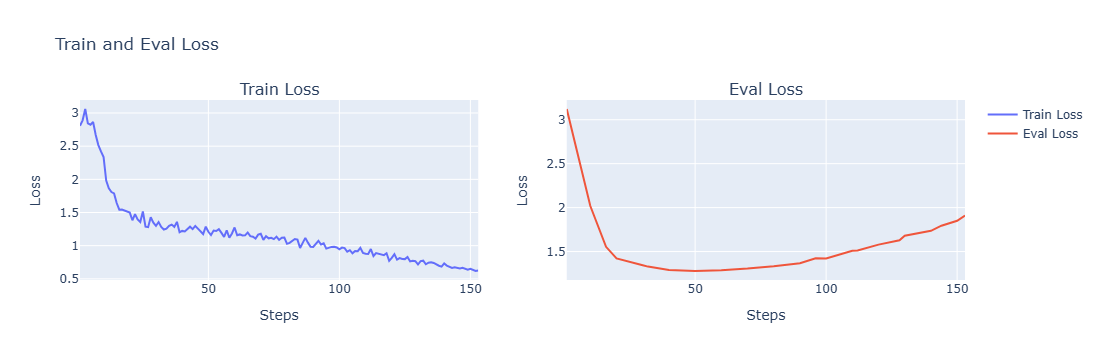

In [48]:
# Plot the train and eval loss metrics using Plotly python library

fig = make_subplots(
    rows=1, cols=2, shared_xaxes=True, subplot_titles=("Train Loss", "Eval Loss")
)

# Add traces
fig.add_trace(
    go.Scatter(x=train_loss[0], y=train_loss[1], name="Train Loss", mode="lines"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=eval_loss[0], y=eval_loss[1], name="Eval Loss", mode="lines"),
    row=1,
    col=2,
)

# Add figure title
fig.update_layout(title="Train and Eval Loss", xaxis_title="Steps", yaxis_title="Loss")

# Set x-axis title
fig.update_xaxes(title_text="Steps")

# Set y-axes titles
fig.update_yaxes(title_text="Loss")

# Show plot
fig.show()

## Step8: Load the Tuned Model

 - Load the fine-tuned model using `GenerativeModel` class with the tuning job model endpoint name.

 - Test the tuned model with the following prompt

In [50]:
prompt

'\nHold your arm out flat in front of you with your elbow bent. The top of your forearm should form a level surface. Apply a line of lotion from the back of your hand up your arm almost to the crease of your elbow. Squeeze lotion onto both forearms.  Do not rub the lotion into your arms, rather let it sit on your arm in the line you squeezed. You can use as much or as little lotion as you feel is necessary to cover your back completely. Bend your elbows and reach both of your arms behind you, placing the lotion covered forearms against your back. Depending on how flexible you are, this may hurt a little. It might be easier to place one arm behind your back at a time. If you have shoulder pain or are not very flexible, this method may not work well for you. Rub your forearms and the backs of your hands up and down your back like windshield wipers covering as much of your back as you can. You can use your left arm first to cover your left side and then place your right arm behind and use

In [51]:
if True:
    # Test with the loaded model.
    print("***Testing***")
    print(
        client.models.generate_content(
            model=tuned_model, contents=prompt, config=config
        ).text
    )
else:
    print("State:", tuning_job.state.name.state)
    print("Error:", tuning_job.state.name.error)

***Testing***
Squeeze a line of lotion on your forearm. Place both forearms behind you. Rub your back.


- We can clearly see the difference between summary generated pre and post tuning, as tuned summary is more inline with the ground truth format (**Note**: Pre and Post outputs, might vary based on the set parameters.)

  - *Pre*: `This article describes a method for applying lotion to your back using your forearms as applicators. By squeezing lotion onto your forearms and then reaching behind your back, you can use a windshield wiper motion to spread the lotion across your back. The method acknowledges potential limitations for those with shoulder pain or limited flexibility.`
  - *Post*: `Squeeze a line of lotion on your forearm. Reach behind you and rub your back.`
  - *Ground Truth*:` Squeeze a line of lotion onto the tops of both forearms and the backs of your hands. Place your arms behind your back. Move your arms in a windshield wiper motion.`

## Step9: Evaluation post model tuning

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~5 mins for the evaluation on the provided batch. ⚠️</b>
</div>

In [52]:
# run evaluation
evaluation_df_post_tuning = run_evaluation(tuned_model, corpus_batch)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [53]:
evaluation_df_post_tuning.head()

,document,summary,generated_summary,scores,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,Hold your arm out flat in front of you with yo...,Squeeze a line of lotion onto the tops of both...,Squeeze a line of lotion on your forearm. Reac...,"{'rouge1': (0.5384615384615384, 0.451612903225...",0.538462,0.451613,0.491228,0.200000,0.166667,0.181818,0.423077,0.354839,0.385965
1,"As you continue playing, surviving becomes pai...",Make a Crock Pot for better food. Create an Al...,Craft a Crock Pot. Create an Alchemy Engine. M...,"{'rouge1': (0.7333333333333333, 0.611111111111...",0.733333,0.611111,0.666667,0.500000,0.411765,0.451613,0.666667,0.555556,0.606061
2,Go to https://www.4kdownload.com/products/prod...,Download the 4K Video Downloader setup file. I...,Go to the 4K Video Downloader page and downloa...,"{'rouge1': (0.7755102040816326, 0.644067796610...",0.775510,0.644068,0.703704,0.541667,0.448276,0.490566,0.632653,0.525424,0.574074
3,You should know that vaginoplasty can treat a ...,Consider the health of your bladder. Find a so...,Consider vaginoplasty for a cystocele. Think a...,"{'rouge1': (0.3548387096774194, 0.392857142857...",0.354839,0.392857,0.372881,0.066667,0.074074,0.070175,0.258065,0.285714,0.271186
4,If you want to gather data on the frequency of...,Gather data to be graphed. Choose your range b...,Decide on your bins. Sort the data and count t...,"{'rouge1': (0.6, 0.5217391304347826, 0.5581395...",0.600000,0.521739,0.558140,0.210526,0.181818,0.195122,0.550000,0.478261,0.511628


In [54]:
evaluation_df_post_tuning_stats = evaluation_df_post_tuning.dropna().describe()

In [55]:
# Statistics of the evaluation dataframe post model tuning.
evaluation_df_post_tuning_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.493951,0.458216,0.455000,0.214626,0.202430,0.199734,0.416691,0.386909,0.383445
std,0.172775,0.175645,0.151141,0.142568,0.137518,0.128955,0.165688,0.163739,0.143555
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380542,0.378739,0.369939,0.111111,0.103947,0.089921,0.300000,0.303261,0.288296
50%,0.488095,0.454545,0.475595,0.194600,0.189833,0.181818,0.395652,0.378022,0.380366
75%,0.626157,0.557796,0.551932,0.295588,0.285714,0.276341,0.540210,0.480000,0.476546
max,0.846154,0.857143,0.818182,0.636364,0.705882,0.585366,0.833333,0.833333,0.727273


In [56]:
print(
    "Mean rougeL_precision is", evaluation_df_post_tuning_stats.rougeL_precision["mean"]
)

Mean rougeL_precision is 0.4166907119833829


#### Improvement

In [57]:
improvement = round(
    (
        (
            evaluation_df_post_tuning_stats.rougeL_precision["mean"]
            - evaluation_df_stats.rougeL_precision["mean"]
        )
        / evaluation_df_stats.rougeL_precision["mean"]
    )
    * 100,
    2,
)
print(
    f"Model tuning has improved the rougeL_precision by {improvement}% (result might differ based on each tuning iteration)"
)

Model tuning has improved the rougeL_precision by 179.99% (result might differ based on each tuning iteration)


## Conclusion

Performance could be further improved:
- By adding more training samples. In general, improve your training data quality and/or quantity towards getting a more diverse and comprehensive dataset for your task
- By tuning the hyperparameters, such as epochs and learning rate multiplier
  - To find the optimal number of epochs for your dataset, we recommend experimenting with different values. While increasing epochs can lead to better performance, it's important to be mindful of overfitting, especially with smaller datasets. If you see signs of overfitting, reducing the number of epochs can help mitigate the issue
- You may try different prompt structures/formats and opt for the one with better performance